In [8]:
import yfinance as yf
import pandas as pd
import os

# symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "AMZN"]
symbols = ["AAPL"]



# Define the stock symbol and the time period
symbol = "AAPL"
start_date = "2007-10-26"  # 16 years ago from today
end_date = "2023-10-26"    # Today's date

# Fetch historical data
filename = f"{symbol}_{start_date}_to_{end_date}.csv"
if os.path.exists(filename):
    print("CSV exists, skipping download:", filename)
else:
    data = yf.download(symbol, start=start_date, end=end_date)
    data.to_csv(filename)
    print("Saved CSV:", filename)

# load CSV back into `data`
data = pd.read_csv(filename, index_col=0, parse_dates=True)
print("Loaded CSV:", filename, "rows:", len(data))
# show data head


# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()


CSV exists, skipping download: AAPL_2007-10-26_to_2023-10-26.csv
Loaded CSV: AAPL_2007-10-26_to_2023-10-26.csv rows: 4029


C:\Users\Lau\AppData\Local\Temp\ipykernel_23036\961772420.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
0,2007-10-26,5.544715881347656,5.564829018545802,5.4900792201180035,5.562427354208876,706876800
1,2007-10-29,5.556423664093018,5.601454473413475,5.544716351082299,5.56723075371293,540554000
2,2007-10-30,5.613760948181152,5.684908641045085,5.545615335321901,5.58914469376627,939414000
3,2007-10-31,5.702322483062744,5.707425619850116,5.552221642521101,5.632675006861493,833310800
4,2007-11-01,5.626969814300537,5.706823535120749,5.4036198830415,5.661792738150263,805036400


In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [10]:
# ...existing code...
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Parameters (tune as needed)
SEQ_LEN = 60        # number of past days used to predict
HORIZON = 1         # predict 1 day ahead
BATCH_SIZE = 64
TRAIN_RATIO = 0.8

# 1) prepare series (use Close price)
series = data["Close"].dropna().values.astype(np.float32).reshape(-1, 1)
n_total = len(series)
if n_total < SEQ_LEN + HORIZON:
    raise ValueError("Not enough data for the chosen SEQ_LEN/HORIZON")

# 2) train / test split indices for scaling (avoid leakage)
train_end = int(n_total * TRAIN_RATIO)
train_series = series[:train_end]
# MinMax scaler using train set
train_min = train_series.min(axis=0)
train_max = train_series.max(axis=0)
scale_denom = (train_max - train_min)
scale_denom[scale_denom == 0] = 1.0  # avoid div by zero

def scale(x):
    return (x - train_min) / scale_denom

series_scaled = scale(series)

# 3) create sequences and targets
def create_sequences(data_arr, seq_len, horizon):
    xs, ys = [], []
    for i in range(0, len(data_arr) - seq_len - (horizon - 1)):
        x = data_arr[i : i + seq_len]
        y = data_arr[i + seq_len + (horizon - 1)]
        xs.append(x)
        ys.append(y)
    return np.stack(xs), np.stack(ys)

X_all, y_all = create_sequences(series_scaled, SEQ_LEN, HORIZON)

# 4) split sequences into train / test by sequence count
n_seq = len(X_all)
train_seq_count = int(n_seq * TRAIN_RATIO)

X_train, y_train = X_all[:train_seq_count], y_all[:train_seq_count]
X_test,  y_test  = X_all[train_seq_count:], y_all[train_seq_count:]

# 5) Dataset wrapper
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()       # shape: (N, seq_len, 1)
        self.y = torch.from_numpy(y).float()       # shape: (N, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(X_train, y_train)
test_dataset  = SequenceDataset(X_test,  y_test)

# 6) DataLoaders (assign train_loader as requested)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# 7) quick sanity print
print(f"Total series length: {n_total}, sequences: {n_seq}")
print(f"Train sequences: {len(train_dataset)}, Test sequences: {len(test_dataset)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# ...existing code...


Total series length: 4027, sequences: 3967
Train sequences: 3173, Test sequences: 794
X_train shape: (3173, 60, 1), y_train shape: (3173, 1)


In [ ]:
import platform


# device selection: prefer CUDA only when running on Windows and CUDA is available
device = torch.device("cuda" if (platform.system() == "Windows" and torch.cuda.is_available()) else "cpu")
print("Platform:", platform.system(), "CUDA available:", torch.cuda.is_available(), "Using device:", device)


Platform: Windows CUDA available: True Using device: cuda


In [12]:


# training hyperparams
HIDDEN_SIZE = 64
LR = 1e-3
EPOCHS = 20

# model + simple linear head that maps last hidden state -> scalar prediction
model = NaiveCustomLSTM(input_sz=1, hidden_sz=HIDDEN_SIZE).to(device)
head = nn.Linear(HIDDEN_SIZE, 1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=LR)

for epoch in range(1, EPOCHS + 1):
    model.train()
    head.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)          # shape: (B, seq_len, 1)
        yb = yb.to(device)          # shape: (B, 1)
        optimizer.zero_grad()
        out_seq, _ = model(xb)      # out_seq: (B, seq_len, hidden)
        last_h = out_seq[:, -1, :]  # take last time-step hidden (B, hidden)
        preds = head(last_h)        # (B, 1)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # validation / test eval
    model.eval()
    head.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out_seq, _ = model(xb)
            preds = head(out_seq[:, -1, :])
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss = val_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else float("nan")

    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.6f}  val_loss: {val_loss:.6f}")
    
# export model
torch.save({
    'model_state_dict': model.state_dict(),
    'head_state_dict': head.state_dict(),
}, 'lstm_price_model.pth')

Epoch 1/20 — train_loss: 0.022554  val_loss: 0.141182
Epoch 2/20 — train_loss: 0.000715  val_loss: 0.027191
Epoch 3/20 — train_loss: 0.000211  val_loss: 0.019061
Epoch 4/20 — train_loss: 0.000182  val_loss: 0.007875
Epoch 5/20 — train_loss: 0.000158  val_loss: 0.004631
Epoch 6/20 — train_loss: 0.000142  val_loss: 0.003014
Epoch 7/20 — train_loss: 0.000124  val_loss: 0.002584
Epoch 8/20 — train_loss: 0.000144  val_loss: 0.002642
Epoch 9/20 — train_loss: 0.000163  val_loss: 0.005250
Epoch 10/20 — train_loss: 0.000118  val_loss: 0.007370
Epoch 11/20 — train_loss: 0.000106  val_loss: 0.010773
Epoch 12/20 — train_loss: 0.000105  val_loss: 0.008249
Epoch 13/20 — train_loss: 0.000102  val_loss: 0.009479
Epoch 14/20 — train_loss: 0.000098  val_loss: 0.008141
Epoch 15/20 — train_loss: 0.000100  val_loss: 0.012481
Epoch 16/20 — train_loss: 0.000108  val_loss: 0.019915
Epoch 17/20 — train_loss: 0.000107  val_loss: 0.010002
Epoch 18/20 — train_loss: 0.000106  val_loss: 0.006487
Epoch 19/20 — train

In [41]:
# load checkpoint (use in-memory ckpt if present, otherwise load file)
state =  torch.load('lstm_price_model.pth', map_location=device)
print(state['model_state_dict'].keys())
print(state['head_state_dict'].keys())

odict_keys(['W_i', 'U_i', 'b_i', 'W_f', 'U_f', 'b_f', 'W_c', 'U_c', 'b_c', 'W_o', 'U_o', 'b_o'])
odict_keys(['weight', 'bias'])


In [38]:

# instantiate model + head (reuse HIDDEN_SIZE and device from notebook)
model = NaiveCustomLSTM(input_sz=1, hidden_sz=HIDDEN_SIZE).to(device)
head = nn.Linear(HIDDEN_SIZE, 1).to(device)

# load weights
model.load_state_dict(state['model_state_dict'])
head.load_state_dict(state['head_state_dict'])

model.eval()
head.eval()

# prepare test data tensor
X_test_tensor = torch.from_numpy(X_test).float().to(device)  # shape: (N, seq_len, 1)

# batch inference
preds_batches = []
with torch.no_grad():
    for i in range(0, X_test_tensor.size(0), BATCH_SIZE):
        xb = X_test_tensor[i : i + BATCH_SIZE]
        out_seq, _ = model(xb)
        preds = head(out_seq[:, -1, :])        # shape (B,1)
        if i == 0:
          print(out_seq.shape, out_seq[:, -1, :].shape)

          print(preds.shape)
          print(preds[:5])
        preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
# show list length and shapes of elements and total concatenated shape

print(len(preds_batches), len(preds_batches[0]))
preds_scaled = torch.cat(preds_batches, dim=0).squeeze(-1).numpy()  # shape: (N,)
print(torch.cat(preds_batches, dim=0).shape)
print(preds_scaled.shape)


# inverse scale to original price units
preds_unscaled = preds_scaled * scale_denom + train_min

# optional: compare first 10 predictions with scaled targets (and unscale targets)
y_test_unscaled = y_test * scale_denom + train_min
print("First 10 predicted prices (unscaled):\n", preds_unscaled[:10].flatten())
print("First 10 true prices (unscaled):\n", y_test_unscaled[:10].flatten())

# store results in notebook variables for later use
  # scaled predictions (same scale as X/y arrays)


torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[1.1469],
        [1.1596],
        [1.1783],
        [1.1914],
        [1.1866]], device='cuda:0')
13 64
torch.Size([794, 1])
(794,)
First 10 predicted prices (unscaled):
 [126.49609 127.87053 129.89438 131.3118  130.79817 130.006   127.67618
 125.9641  123.68655 121.31752]
First 10 true prices (unscaled):
 [125.51949  130.51926  127.81511  117.582115 117.659935 109.74201
 114.11924  110.39374  108.94438  112.21272 ]


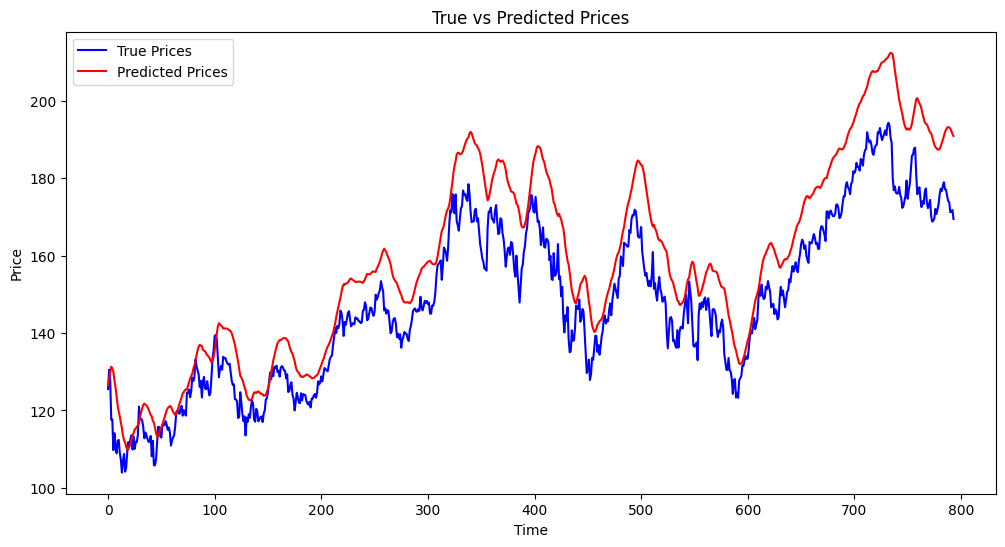

In [31]:
#matplotlib inline showing predicted vs true prices
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled, label='True Prices', color='blue')
plt.plot(preds_unscaled, label='Predicted Prices', color='red')
plt.title('True vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()